<a href="https://colab.research.google.com/github/Ankan1998/Hackathons/blob/main/Coursera_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predict Future Sales

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm, tqdm_notebook

import sklearn
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pickle
import gc
import os
import zipfile

### Kaggle download

In [2]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.9-cp36-none-any.whl size=73265 sha256=799050deaf657213b41823260b25336e78eb4fe57a5e641d26f130eefc612799
  Stored in directory: /root/.cache/pip/wheels/68/6d/9b/7a98271454edcba3b56328cbc78c037286e787d004c8afee71
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c competitive-data-science-predict-future-sales -p '/tmp'

 93% 14.0M/15.1M [00:00<00:00, 52.1MB/s]
100% 15.1M/15.1M [00:00<00:00, 67.5MB/s]


In [52]:
local_zip='/tmp/competitive-data-science-predict-future-sales.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/content")
zip_ref.close()

### Load Dataset

In [54]:
sales = pd.read_csv('/content/sales_train.csv')
shops = pd.read_csv('/content/shops.csv')
items = pd.read_csv('/content/items.csv')
items_categories = pd.read_csv('/content/item_categories.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')
test_data = pd.read_csv('/content/test.csv')

In [55]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## Exploratory Data Analysis

### Number of items per category

In [56]:
items_per_category = items.item_category_id.value_counts().iloc[:25]
items_per_category = items_per_category.sort_index(sort_remaining=True)

Text(0.5, 1.0, 'Number of items per category')

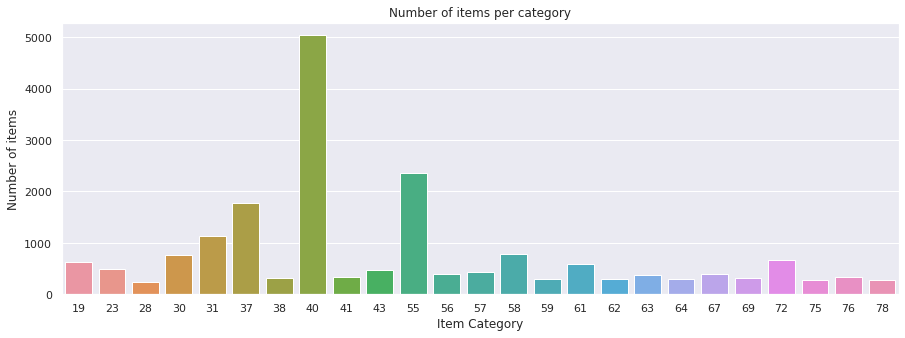

In [57]:
sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(items_per_category.index, items_per_category.values)
plt.xlabel("Item Category")
plt.ylabel("Number of items")
plt.title("Number of items per category")

### Important items

In [58]:
imp_items = sales.groupby('item_id')['item_cnt_day'].sum()
imp_items = imp_items.sort_values(ascending=False)[:25]

Text(0.5, 1.0, 'Important items')

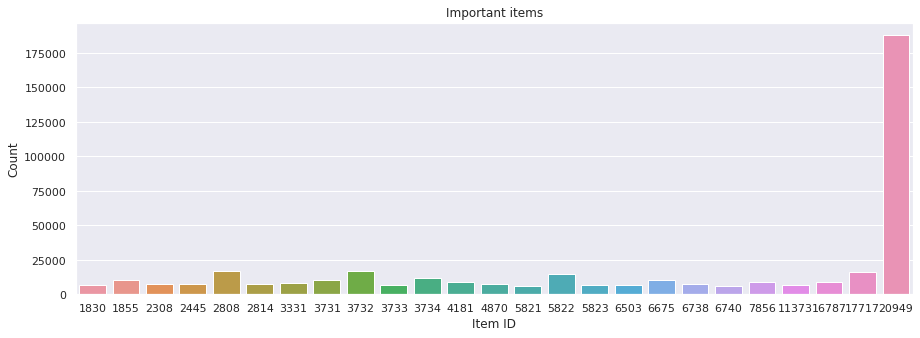

In [59]:
sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(imp_items.index, imp_items.values)
plt.xlabel("Item ID")
plt.ylabel("Count")
plt.title("Important items")

### Important shops

In [60]:
imp_shops = sales.groupby('shop_id')['item_cnt_day'].sum()
imp_shops = imp_shops.sort_values(ascending=False)[:25]

Text(0.5, 1.0, 'Important shops')

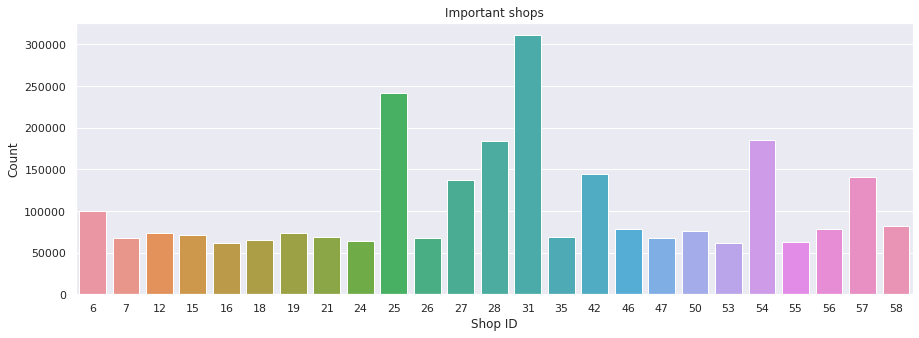

In [61]:
sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(imp_shops.index, imp_shops.values)
plt.xlabel("Shop ID")
plt.ylabel("Count")
plt.title("Important shops")

### Items per month

In [62]:
item_count_per_month = sales.groupby('date_block_num')['item_cnt_day'].sum()

Text(0.5, 1.0, 'Items sold per month')

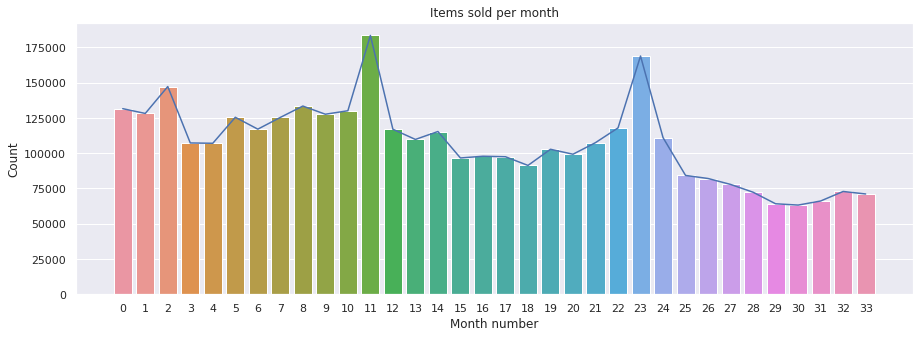

In [63]:
plt.figure(figsize=(15,5))
sns.barplot(item_count_per_month.index, item_count_per_month.values)
plt.plot(item_count_per_month.index, item_count_per_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Items sold per month")

## Preprocessing and Feature Engineering

### Test data - Add date_block_num=34

In [64]:
test_block = sales['date_block_num'].max() + 1
test_data['date_block_num'] = test_block
test_data = test_data.drop(columns=['ID'])
test_data.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [65]:
idx_cols = ['shop_id', 'item_id', 'date_block_num']
structure = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    structure.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

structure = pd.DataFrame(np.vstack(structure), columns = idx_cols, dtype=np.int32)
structure = pd.concat([structure, test_data])

In [66]:
structure.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [67]:
def dftype(df):    
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

### Create features by grouping shops, items and month

In [68]:
gb = sales.groupby(idx_cols, as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target'})
data_final = pd.merge(structure, gb, how='left', on=idx_cols).fillna(0)
gb = sales.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
data_final = pd.merge(data_final, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)
gb = sales.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_item'})
data_final = pd.merge(data_final, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)
data_final = dftype(data_final)
del structure, gb 
gc.collect();

In [69]:
data_final.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0


### Create features using previous months data - Different lags

In [70]:
ren_col = list(data_final.columns.difference(idx_cols))
shift_range = [1, 2, 3, 4, 5, 12]
for month_shift in tqdm_notebook(shift_range):
    shift_tr = data_final[idx_cols + ren_col].copy()
    shift_tr['date_block_num'] = shift_tr['date_block_num'] + month_shift
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in ren_col else x
    shift_tr = shift_tr.rename(columns=foo)
    data_final = pd.merge(data_final, shift_tr, on=idx_cols, how='left').fillna(0)   
del shift_tr

In [71]:
data_final.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
0,59,22154,0,1.0,2017.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,2017.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,2017.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,2017.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Add "item category id" as a feature

In [72]:
data_final = data_final[data_final['date_block_num'] >= 12]
cols_fit = [col for col in data_final.columns if col[-1] in [str(item) for item in shift_range]]
drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
drop_cols = list(set(list(data_final.columns)) - (set(cols_fit)|set(idx_cols))) + ['date_block_num']
item_cat_map = items[['item_id', 'item_category_id']].drop_duplicates()
data_final = pd.merge(data_final, item_cat_map, how='left', on='item_id')
data_final = dftype(data_final)
gc.collect()

15

In [73]:
drop_cols

['target_shop', 'target', 'target_item', 'date_block_num']

### Final data - Will be used for training and validation

In [74]:
data_final.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


### Split data - Train and Test

In [75]:
dates = data_final['date_block_num']
dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

In [76]:
X_train = data_final.loc[dates <  test_block].drop(drop_cols, axis=1)
X_test =  data_final.loc[dates == test_block].drop(drop_cols, axis=1)
y_train = data_final.loc[dates <  test_block, 'target'].values
y_test =  data_final.loc[dates == test_block, 'target'].values

In [77]:
X_train.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


In [78]:
y_train

array([ 4.,  3., 14., ...,  0.,  0.,  0.], dtype=float32)

### Target range - Clip it to [0, 20]

In [79]:
target_range = [0, 20]
target_range

[0, 20]

## Modelling

### Linear Regression

In [80]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values).clip(*target_range)

In [81]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lr})
submission.to_csv('/content/submission_linear_regression.csv', index=False)

In [82]:
submission.head()

,ID,item_cnt_month
0,0,0.595136
1,1,0.101658
2,2,0.955156
3,3,0.234573
4,4,0.118508


### LightGBM

In [86]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'verbose':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.7, 
               'learning_rate': 0.03, 
               'bagging_seed': 2**7,
               'num_leaves': 2**8,
               'bagging_freq':1,
               'objective': 'mse', 
               
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 150)
pred_lgb = model.predict(X_test).clip(*target_range)

In [88]:
pkl_filename = "/content/lgbm.pkl"  
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [87]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lgb})
submission.to_csv('/content/submission_lgb.csv', index=False)